# ViT

In [ ]:
!pip install transformers torchmetrics

import os
import torch
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Precision, Recall, F1Score
import torch.nn as nn  # Importing nn module
from PIL import Image
from collections import Counter
from random import choice
from collections import defaultdict


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to our dataset
train_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/val'
test_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/test'

def analyze_dataset(path):
    class_counts = Counter()
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_dir] = count
    return class_counts


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(train_path, transform=transform)
test_ds = datasets.ImageFolder(test_path, transform=transform)
valid_ds = datasets.ImageFolder(valid_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=20, shuffle=False)
valid_loader = DataLoader(valid_ds, batch_size=20, shuffle=False)


from transformers import ViTForImageClassification
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm

# Configuration and Model Initialization
num_classes = len(train_ds.classes)
config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Training and Evaluation Functions
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in tqdm(loader, desc="Training"):
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return avg_loss, accuracy

    from collections import defaultdict

def evaluate_per_class(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = defaultdict(int)
    total_samples = defaultdict(int)

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            for pred, true_label in zip(predicted, labels):
                if pred == true_label:
                    correct_predictions[true_label.item()] += 1
                total_samples[true_label.item()] += 1

    accuracy_per_class = {class_idx: correct_predictions[class_idx] / total_samples[class_idx] for class_idx in correct_predictions}
    return accuracy_per_class

# Training Loop
num_epochs = 20  # Define the number of epochs
early_stop_patience = 3  # Number of epochs to wait after last improvement
best_valid_loss = float('inf')  # Initialize with a large value
epochs_since_improvement = 0  # Initialize counter

# Existing Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)

    # Validation phase
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)
    valid_accuracy_per_class = evaluate_per_class(model, valid_loader, criterion, device)

    # Print statements you already have
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")


    # Early Stopping Logic
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement == early_stop_patience:
        print("Early stopping triggered")
        break






    scheduler.step()


  # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/public-data/models/my_vit_model.pth')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.2209, Training Accuracy: 0.9595
Validation Loss: 0.0603, Validation Accuracy: 0.9939


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0581, Test Accuracy: 0.9926
Epoch 2/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0382, Training Accuracy: 0.9951
Validation Loss: 0.0219, Validation Accuracy: 0.9976


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0243, Test Accuracy: 0.9951
Epoch 3/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0208, Training Accuracy: 0.9974
Validation Loss: 0.0213, Validation Accuracy: 0.9951


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0350, Test Accuracy: 0.9902
Epoch 4/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0145, Training Accuracy: 0.9985
Validation Loss: 0.0149, Validation Accuracy: 0.9988


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0253, Test Accuracy: 0.9951
Epoch 5/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0100, Training Accuracy: 0.9988
Validation Loss: 0.0195, Validation Accuracy: 0.9963


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0247, Test Accuracy: 0.9951
Epoch 6/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0061, Training Accuracy: 0.9992
Validation Loss: 0.0087, Validation Accuracy: 0.9988


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0287, Test Accuracy: 0.9939
Epoch 7/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0054, Training Accuracy: 0.9991
Validation Loss: 0.0148, Validation Accuracy: 0.9963


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0248, Test Accuracy: 0.9951
Epoch 8/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0043, Training Accuracy: 0.9988
Validation Loss: 0.0111, Validation Accuracy: 0.9963


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0265, Test Accuracy: 0.9951
Epoch 9/20


Training:   0%|          | 0/327 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Training Loss: 0.0036, Training Accuracy: 0.9994
Validation Loss: 0.0112, Validation Accuracy: 0.9963
Early stopping triggered


# **Performance Evaluation**

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0266
Test Accuracy: 0.9951
 Precision: 0.9951
 Recall: 0.9951
 F1 Score: 0.9951


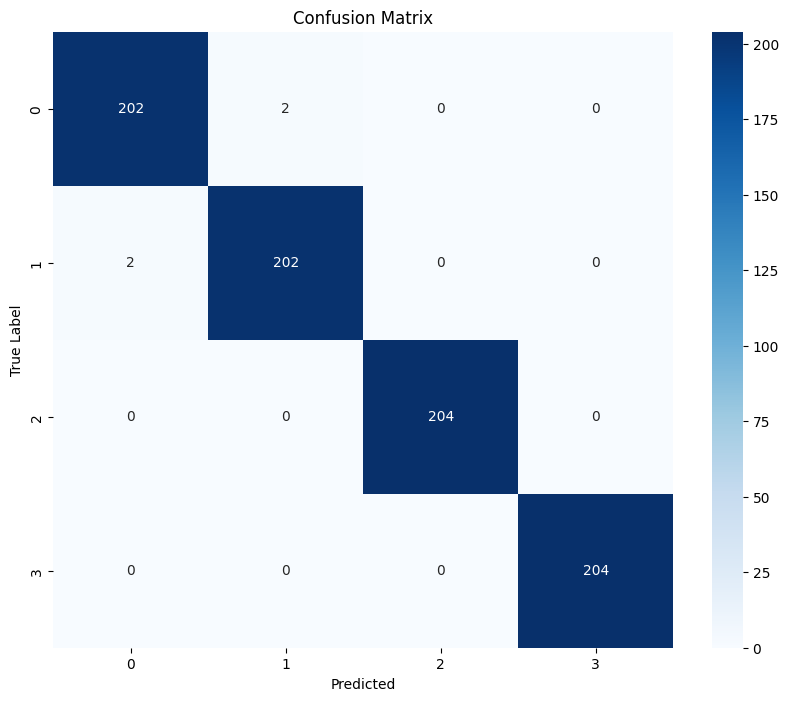

In [ ]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)

    # Compute metrics
    precision = precision_score(all_true_labels, all_predictions, average='macro')
    recall = recall_score(all_true_labels, all_predictions, average='macro')
    f1 = f1_score(all_true_labels, all_predictions, average='macro')

    # Compute confusion matrix
    conf_mat = confusion_matrix(all_true_labels, all_predictions)

    return avg_loss, accuracy, precision, recall, f1, conf_mat

# Evaluate on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1, conf_mat = evaluate(model, test_loader, criterion, device)

# Print the metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f" Precision: {test_precision:.4f}")
print(f" Recall: {test_recall:.4f}")
print(f" F1 Score: {test_f1:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Class 0 - Precision: 0.9902, Recall: 0.9902, F1: 0.9902, Accuracy: 0.9951


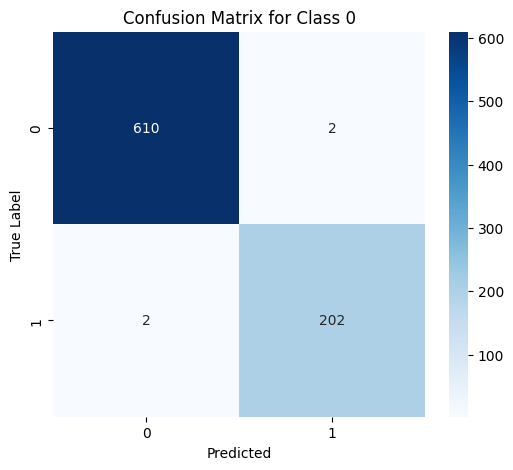

Class 1 - Precision: 0.9902, Recall: 0.9902, F1: 0.9902, Accuracy: 0.9951


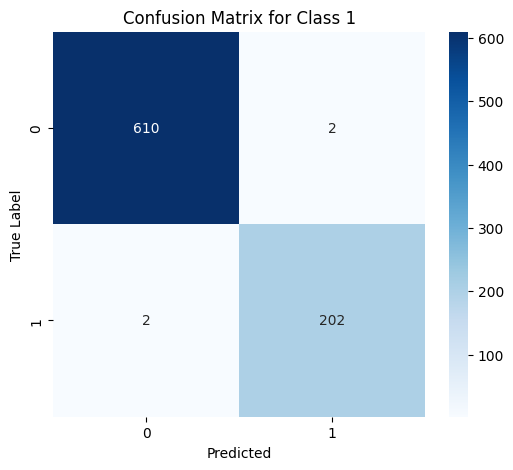

Class 2 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Accuracy: 1.0000


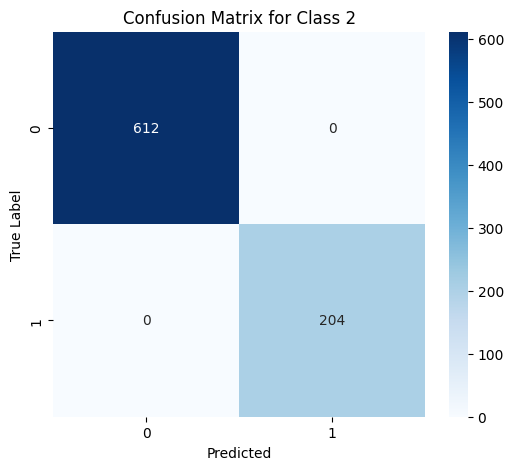

Class 3 - Precision: 1.0000, Recall: 1.0000, F1: 1.0000, Accuracy: 1.0000


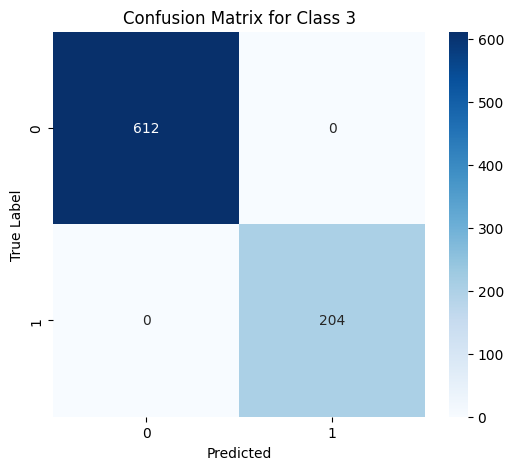

In [ ]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluation function
def evaluate_per_class(model, loader, criterion, device, num_classes):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    metrics_per_class = {}
    conf_matrices = {}

    for class_index in range(num_classes):
        # Treat each class as binary (class vs. not class)
        binary_true = (np.array(all_true_labels) == class_index).astype(int)
        binary_pred = (np.array(all_predictions) == class_index).astype(int)

        # Calculate metrics
        precision = precision_score(binary_true, binary_pred)
        recall = recall_score(binary_true, binary_pred)
        f1 = f1_score(binary_true, binary_pred)
        accuracy = accuracy_score(binary_true, binary_pred)

        # Compute confusion matrix
        conf_mat = confusion_matrix(binary_true, binary_pred)

        metrics_per_class[class_index] = {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
        conf_matrices[class_index] = conf_mat

    return metrics_per_class, conf_matrices

# Number of classes
num_classes = 4

# Evaluate on the test set
metrics_per_class, conf_matrices = evaluate_per_class(model, test_loader, criterion, device, num_classes)

# Print metrics and plot confusion matrices
for class_index in range(num_classes):
    metrics = metrics_per_class[class_index]
    print(f"Class {class_index} - Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}, Accuracy: {metrics['accuracy']:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices[class_index], annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.show()


# **ROC-AUC**

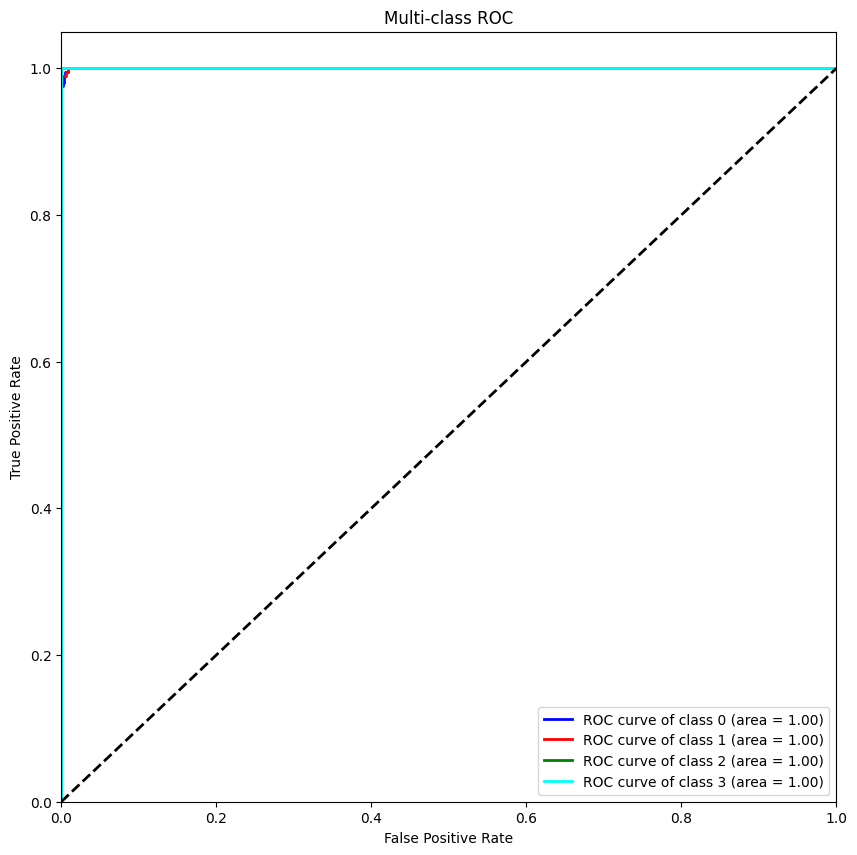

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_and_get_predictions(model, loader, device, n_classes):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_preds.append(probabilities.cpu().numpy())
            all_true.append(labels.cpu().numpy())

    # Binarize the labels
    all_true_bin = label_binarize(np.concatenate(all_true), classes=range(n_classes))
    return all_true_bin, np.concatenate(all_preds)

# Get the test data predictions and true labels
n_classes = len(train_ds.classes)
y_test_bin, y_score = evaluate_and_get_predictions(model, test_loader, device, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown'])
plt.figure(figsize=(10, 10))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
